In [1]:
from diskdict import DiskDict
import random

In [2]:
wikidata = DiskDict('wikidata/diskdict')

In [3]:
with open ('datasets/conll-2003/train.txt', 'r') as f:
    lines = f.readlines()

In [4]:
def process_data(lines):
    sentences = []
    sent = []
    for l in lines:
        if l == '\n' and len(sent) > 0:
            sentences.append(sent)
            sent = []
            continue
        x = l.split()
        sent.append({'word': x[0], 'bio': x[-1]})
    return sentences

In [5]:
def ent_from_sent(sent):
    ents = {}
    in_ent = False
    ent = []
    generic = None
    for x in sent:
        if x['bio'] == 'O' and in_ent:
            try: 
                ents[generic].append(' '.join(ent))
            except KeyError:
                ents[generic] = [' '.join(ent)]
            in_ent = False
            ent = []
            generic = None
            continue
        if x['bio'] != 'O':
            in_ent = True
            if generic is None:
                generic = x['bio'].split('-')[1]
            ent.append(x['word'])
    return ents

In [6]:
def ent_from_data(data):
    ents = {}
    for dt in data:
        ent_part = ent_from_sent(dt)
        for i, x in ent_part.items():
            if i in ents:
                ents[i] += x
            else:
                ents[i] = x
    for i, x in ents.items():
        ents[i] = list(set(x))
    return ents

In [7]:
data = process_data(lines)
entities_by_generics = ent_from_data(data)

In [8]:
entities = set([x for _, t in entities_by_generics.items() for x in t])

In [9]:
entities_matched = {}

In [10]:
ent_id_table = DiskDict('wikidata/ent_id_table')

In [11]:
#wikidata['Q31']

In [12]:
for ent in entities:
    ent = ent.lower()
    if ent_id_table[ent] is not None:
        try: 
            entities_matched[ent] += ent_id_table[ent]
        except KeyError:
            entities_matched[ent] = ent_id_table[ent]
for ent, ids in entities_matched.items():
    entities_matched[ent] = list(set(ids))

In [321]:
len(entities_matched) / len(entities)

0.6287888395688015

In [13]:
import json
with open('wikidata/properties.json', 'r+') as f:
    properties_dict = json.load(f)

In [14]:
properties_dict_inv = {x['label']: t for t, x in properties_dict.items()}

In [15]:
for ent, ids in entities_matched.items():
    if len(ids) > 1:
        print('ambiguity found: {}, {}'.format(ent, ids))

In [16]:
properties_matched = {}
for ent, ids in entities_matched.items():
    id = ids[0]
    for rel in wikidata[id]['relations']:
        if rel not in properties_matched:
            properties_matched[rel] = properties_dict[rel]
    

In [17]:
def filter_by_properties(entities, properties):
    filtered = {}
    for ent, ids in entities.items():
        for id in ids:
            for p in properties:
                if p in wikidata[id]['relations']:
                    try:
                        filtered[ent].append(id)
                        filtered[ent] = list(set(filtered[ent]))
                    except KeyError:
                        filtered[ent] = [id]
    return filtered

In [216]:
properties_to_use = ['record held', 
                     'field of work', 
                     'occupation', 
                     'member of political party', 
                     'instance of', 
                     'genre', 
                     'owner of', 
                     'creator', 
                     'developer', 
                     'subclass of', 
                    'followed by',
                    'follows']
properties_to_use = [properties_dict_inv[x] for x in properties_to_use]

In [217]:
filtered_entities = filter_by_properties(entities_matched, properties_to_use)
len(filtered_entities) / len(entities_matched)

0.9887051230334812

In [218]:
#['{}, {}'.format(x, entities_matched[x][0]) for x in set(entities_matched.keys()) - filtered_entities.keys()]

In [219]:
properties_frequencies = {}
for ent, ids in entities_matched.items():
    for id in ids:
        ppts = list(wikidata[id]['relations'])
        for p in ppts:
            try:
                properties_frequencies[p] += 1
            except KeyError:
                properties_frequencies[p] = 1

In [220]:
ppts, fqs = zip(*sorted(properties_frequencies.items(), reverse=True, key=lambda x: x[1]))

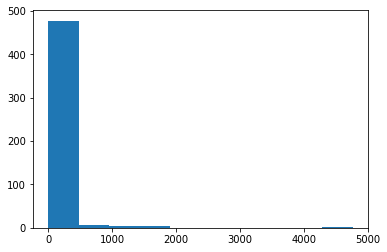

In [221]:
import matplotlib.pyplot as plt
plt.hist(fqs)
plt.show()

In [294]:
ppts_fq = [x for x, y in zip(ppts, fqs) if y >= 10]
properties_to_use = ppts_fq

In [295]:
filtered_entities = filter_by_properties(entities_matched, properties_to_use)
len(filtered_entities) / len(entities_matched)

0.9933440903590157

In [296]:
#[properties_dict[x]['label'] for x in ppts_fq]

In [297]:
nbrs_fq = {}
for ent, ids in entities_matched.items():
    for id in ids:
        for rel, nbr in wikidata[id]['relations'].items():
            if rel not in properties_to_use:
                break
            for n in nbr:
                try:
                    nbrs_fq[n] += 1
                except KeyError:
                    nbrs_fq[n] = 1
    

In [298]:
fq_nbrs = [t for t, x in nbrs_fq.items() if x > 10]
len(fq_nbrs), len(nbrs_fq)

(500, 26352)

In [299]:
def filter_subgraph(entities_ids, allowed_ppts, allowed_nbrs):
    ent_filtered = {}
    for ent in entities_ids:
        rels = {}
        for r, nbrs in wikidata[ent]['relations'].items():
            #r = properties_dict[r]['label']
            if r not in allowed_ppts:
                continue
            for nbr in nbrs:
                if nbr not in allowed_nbrs:
                    continue
                
                #print(r)
                if r not in rels:
                    rels[r] = [nbr]
                else:
                    rels[r].append(nbr)
        if len(rels) > 0:
            ent_filtered[ent] = rels
    return ent_filtered

In [300]:
entities_matched_ids = [ x for i, t in entities_matched.items() for x in t]
matched_ultimate = filter_subgraph(entities_matched_ids, properties_to_use, fq_nbrs)

In [301]:
#matched_ultimate

In [302]:
matched_ultimate_human = {}
# risk: did not consider ambiguity. 
for ent, rels in matched_ultimate.items():
    ent = wikidata[ent]['label'].lower()
    if ent not in entities_matched:
        continue
    rels_human = {}
    for rel, nbrs in rels.items():
        rel = properties_dict[rel]['label']
        nbrs = [wikidata[x]['label'].lower() for x in nbrs if wikidata[x] is not None]
        rels_human[rel] = nbrs
    matched_ultimate_human[ent] = rels_human

In [320]:
matched_ultimate_human['belgium']

{'capital': ['brussels'],
 'continent': ['europe'],
 'country': ['belgium'],
 'described by source': ['armenian soviet encyclopedia',
  'sytin military encyclopedia',
  'brockhaus and efron encyclopedic dictionary',
  'small brockhaus and efron encyclopedic dictionary'],
 'diplomatic relation': ['luxembourg',
  'italy',
  'germany',
  'australia',
  'ukraine',
  'france',
  'united kingdom',
  'canada',
  'indonesia',
  'denmark',
  'turkey',
  'netherlands',
  'uruguay',
  'malaysia',
  'pakistan',
  'taiwan',
  'mexico',
  'democratic republic of the congo',
  'united states of america',
  'russia',
  'india',
  'greece',
  "people's republic of china",
  'georgia',
  'israel',
  'kingdom of the netherlands',
  'hungary'],
 'driving side': ['right'],
 'electrical plug type': ['europlug'],
 'emergency phone number': ['112'],
 'has quality': ['free country'],
 'instance of': ['sovereign state', 'country'],
 'language used': ['dutch', 'german', 'french'],
 'located in time zone': ['cent

In [303]:
entities_type_table = {x.lower(): t for t, ents in entities_by_generics.items() for x in ents}
entities_type_table['belgium']

'LOC'

In [304]:
from torch.utils.data import Dataset, DataLoader
import torch

class PptyData(Dataset):
    def __init__(self, ent_properties, ent_type):
        self.property_table = ent_properties
        self.type_table = ent_type
        self.prepare()
        
    def prepare(self):
        
        self.properties = set([x for _, rels in self.property_table.items()
                              for ptype, ppty in rels.items()
                              for x in ppty])
        
        preserved = ['<pad>']
        self.p2id = {i: t + len(preserved) for t, i in enumerate(self.properties)}
        self.id2p = {i: t for t, i in self.p2id.items()}
        for i, t in enumerate(preserved):
            self.p2id[t] = i
            self.id2p[i] = t
        
        self.types = set([x for _, x in self.type_table.items()])
        self.ents = list([x for x, _ in self.property_table.items()])
        self.t2id = {i: t for t, i in enumerate(self.types)}
        self.id2t = {i: t for t, i in self.t2id.items()}
        
        self.unnested = {x: [t for _, s in rels.items() for t in s] for x, rels in  self.property_table.items()}
        self.max_len = max([len(x) for _, x in self.unnested.items()])
    
    def pad(self, x, max_len):
        gap = len(x) - max_len
        if gap > 0: 
            return x[gap:]
        else:
            return x + [0] * (-gap)
    
    def __getitem__(self, idx):
        ent = self.ents[idx]
        ppty = [self.p2id[x] for x in self.unnested[ent]]
        len_ = len(ppty)
        ppty = self.pad(ppty, self.max_len)
        label = self.t2id[self.type_table[ent]]
        
        return torch.tensor(ppty).long(), torch.tensor(label).long(), len_
    
    def __len__(self):
        return len(self.property_table)

In [305]:
dataset = PptyData(matched_ultimate_human, entities_type_table)

In [306]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [307]:
len(dataset)

3673

In [502]:
class DNFNet(nn.Module):
    def __init__(self, n_vars, n_class, n_dim):
        super(DNFNet, self).__init__()
        self.v_embedding = nn.Embedding(n_vars, n_dim)
        self.y_embedding = nn.Embedding(n_class, n_dim)
        
        #self.f = nn.Sequential(nn.Linear(n_dim*2, n_dim*2),
        self.f = nn.Sequential(nn.Linear(n_dim, n_dim), 
                              nn.ReLU(),
                              nn.Linear(n_dim, n_dim))
        
        self.g = nn.Sequential(nn.Linear(n_dim, n_dim),
                              nn.ReLU(),
                              nn.Linear(n_dim, n_dim))
        
        self.out = nn.Linear(n_dim, n_class)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def predict(self, vars, mask=None):
        """
        vars: N * max_len
        mask: N * max_len
        """
        l_embedded = self.y_embedding.weight.unsqueeze(0)                # 1 * y * d
        l_embedded = l_embedded.repeat(vars.shape[0], 1, 1) # N * y * d
        l_embedded = l_embedded.transpose(1, 2)     # N * d * y
        v_embedded = self.v_embedding(vars)         # N * max_len * d
        scores = torch.bmm(v_embedded, l_embedded)  # N * max_len * y
        
        
        norm_1 = l_embedded.norm(dim=1).unsqueeze(1) # N * 1 * y
        norm_1 = norm_1.repeat(1, v_embedded.shape[1], 1) # N * max_len * y
        norm_2 = v_embedded.norm(dim=2).unsqueeze(2)  # N * max_len * 1
        norm_2 = norm_2.repeat(1, 1, l_embedded.shape[2]) # N * max_len * y
        
        scores = scores / norm_1
        scores = scores / norm_2
    
        
        mask = mask.unsqueeze(-1).repeat(1, 1, scores.shape[2])
        if mask is not None:
            scores = scores * mask
        scores = scores.sum(1) 
        #print(mask[:,:,0].sum(1))
        #print(scores / mask.sum(1))
        return scores
        
        
    def forward(self, vars, label, neg_vars, mask=None):
        """
        N = n_batch
        vars: N * max_len
        label: N
        neg_vars: N*k
        mask: N*max_len
        """
        
        vars_embedded = self.v_embedding(vars) # N * max_len * d
        label_embedded = self.y_embedding(label) # N * d
        neg_vars_embedded = self.v_embedding(neg_vars) # N * k * d
        
        # correlative score.
        score_pos = torch.bmm(vars_embedded, label_embedded.unsqueeze(2)).squeeze()  # N * max_len 
        score_neg = torch.bmm(neg_vars_embedded, label_embedded.unsqueeze(2)).squeeze()
        
        if mask is not None:
            score_pos[~mask] = float('inf')
        
        score_pos = torch.sum(F.logsigmoid(score_pos), 1)  # N 
        score_neg = torch.sum(F.logsigmoid(score_neg) - score_neg, 1)
        
            
        # predictive loss.
        scores_pred = self.predict(vars, mask)
        loss_pred = self.criterion(scores_pred, label)
        
        return loss_pred, -score_pos.mean(), -score_neg.mean()

In [503]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train, test = torch.utils.data.random_split(dataset, [train_size, test_size])

In [504]:
dataloader = DataLoader(train, batch_size=32, shuffle=True)

In [505]:
n_pptys = len(dataset.p2id)
n_class = len(dataset.types)
model = DNFNet(n_vars=n_pptys, n_class=n_class, n_dim=50)

In [514]:

n_epochs = 100
device = 'cpu'

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for i_epoch in range(n_epochs):
    loss_history = []
    for t in dataloader:
        optimizer.zero_grad()
        vars, label, lens = t
        mask = (torch.arange(vars.shape[1])[None, :] < lens[:, None]).to(device)
        vars, label = vars.to(device), label.to(device)

        neg_vars = torch.tensor([random.sample(range(n_pptys), 3) for _ in label]).to(device)
        
        loss_pred, loss_var, loss_var_neg = model(vars, label, neg_vars, mask)
        loss =  loss_pred + loss_var  + 0.1 * loss_var_neg
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        
    print('[{}/{}] {}, {}, {}, {}'.format(i_epoch+1, n_epochs, sum(loss_history[-100:])/100, 
                                          loss_pred.item(), loss_var.item(), loss_var_neg.item()))

[1/100] 1.1492956364154816, 0.6019256711006165, 0.18109987676143646, 5.07576322555542
[2/100] 1.1305459690093995, 0.5083239078521729, 0.2302677184343338, 5.0521135330200195
[3/100] 1.137179455757141, 0.7802472710609436, 0.18527589738368988, 5.282356262207031
[4/100] 1.1410690724849701, 0.77144455909729, 0.5096222758293152, 4.940199375152588
[5/100] 1.1317071294784546, 0.4889043867588043, 0.1753424108028412, 5.112304210662842
[6/100] 1.1274899446964264, 0.6095163226127625, 0.13084371387958527, 6.142074108123779
[7/100] 1.1312047457695007, 0.9689075946807861, 0.2166508138179779, 4.827122211456299
[8/100] 1.1336204779148102, 0.8447151184082031, 0.16659358143806458, 3.899646520614624
[9/100] 1.1354799246788025, 0.7938263416290283, 0.2291933000087738, 5.463413715362549
[10/100] 1.1370738816261292, 0.7673066854476929, 0.15311069786548615, 3.3468401432037354
[11/100] 1.127251274585724, 0.7933196425437927, 0.18218354880809784, 4.522147178649902
[12/100] 1.1331346368789672, 0.7142611742019653, 

KeyboardInterrupt: 

In [515]:
tester = DataLoader(train, batch_size=len(train))
t = next(iter(tester))
vars, label, lens = t
mask = (torch.arange(vars.shape[1])[None, :] < lens[:, None]).to(device)
vars, label = vars.to(device), label.to(device)

neg_vars = torch.tensor([random.sample(range(n_pptys), 3) for _ in label]).to(device)

scores = model.predict(vars, mask)
y_pred = scores.argmax(1)
(y_pred == label).float().mean()

tensor(0.7367)

In [516]:
tester = DataLoader(test, batch_size=len(test))
t = next(iter(tester))
vars, label, lens = t
mask = (torch.arange(vars.shape[1])[None, :] < lens[:, None]).to(device)
vars, label = vars.to(device), label.to(device)

neg_vars = torch.tensor([random.sample(range(n_pptys), 3) for _ in label]).to(device)

scores = model.predict(vars, mask)
y_pred = scores.argmax(1)
(y_pred == label).float().mean()

tensor(0.7332)

# Now I want to see the "correlation" between properties.

In [335]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
v_pca = PCA(n_components=2).fit_transform(model.v_embedding.weight.detach().numpy())
sns.scatterplot(x=v_pca[:,0], y=v_pca[:,1])
plt.title(r'Low dimension representation of $\mathfrak{V}$', fontsize=20)
plt.savefig('figs/original.pdf')
plt.show()

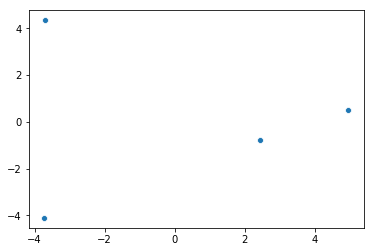

In [388]:
y_pca = PCA(n_components=2).fit_transform(model.y_embedding.weight.detach().numpy())
sns.scatterplot(x=y_pca[:,0], y=y_pca[:,1])
plt.show()

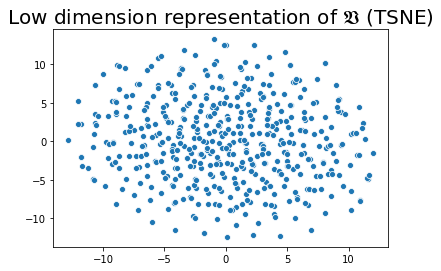

In [439]:
v_tsne = TSNE(n_components=2).fit_transform(model.v_embedding.weight.detach().numpy())
sns.scatterplot(x=v_tsne[:,0], y=v_tsne[:,1])
plt.title(r'Low dimension representation of $\mathfrak{V}$ (TSNE)', fontsize=20)
plt.savefig('original.pdf', bbox_inches='tight')
plt.show()

## Map the variables to a more "meaningful" space
Suppose the property embedding is $v$, let $M = \sum y_i y_i^T$, we define $u=\sqrt{M}v$ and see what happens

Matrix is singular and may not have a square root.
Matrix is singular and may not have a square root.
Matrix is singular and may not have a square root.
Matrix is singular and may not have a square root.


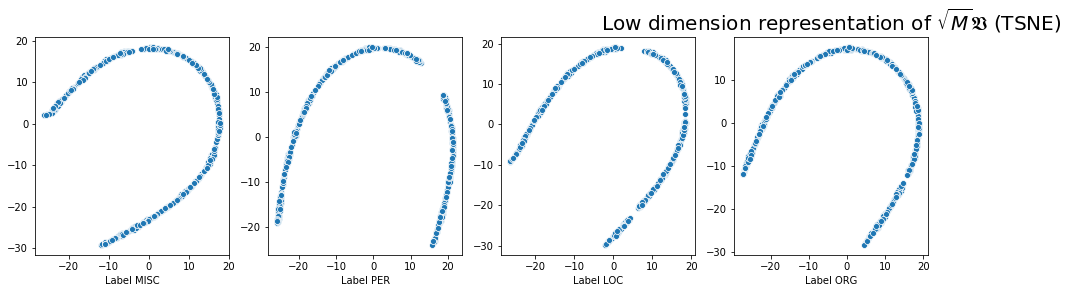

In [489]:

#M = 0
import numpy as np
import scipy
Y = model.y_embedding.weight.detach().numpy()
#M = Y.T.dot(Y)

fig, axes = plt.subplots(1,4, figsize=(16,4))
for idx in range(4):
    M = Y[idx].reshape(len(Y[idx]), 1).dot(Y[idx].reshape(1, len(Y[idx])))
    M = (M + M.T)/2  # for accuracy 
    Msq = scipy.linalg.sqrtm(M).real  # discard imaginary part; supposed to be real.
    X = model.v_embedding.weight.detach().numpy()
    U = X.dot(Msq)
    
    u_pca = TSNE(n_components=2).fit_transform(U)
    
    sns.scatterplot(x=u_pca[:,0], y=u_pca[:,1], ax=axes[idx])
    axes[idx].set_xlabel('Label {}'.format(dataset.id2t[idx]))
    
plt.title(r'Low dimension representation of $\sqrt{M}\mathfrak{V}$ (TSNE)', fontsize=20)
plt.savefig('transformed.pdf', bbox_inches='tight')
plt.show()

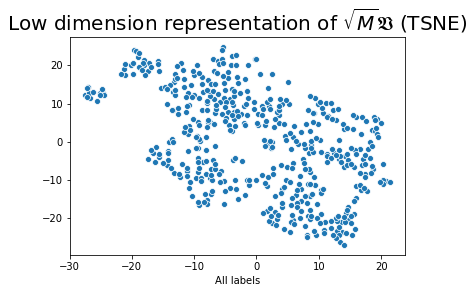

In [497]:

#Y = model.y_embedding.weight.detach().numpy()

#Y = np.random.randn(Y.shape[0], Y.shape[1])
M = Y.T.dot(Y)
#M = np.random.random(M.shape)
M = (M + M.T)/2  # for accuracy 
Msq = scipy.linalg.sqrtm(M).real  # discard imaginary part; supposed to be real.
X = model.v_embedding.weight.detach().numpy()
U = X.dot(Msq)

u_pca = TSNE(n_components=2).fit_transform(U)

sns.scatterplot(x=u_pca[:,0], y=u_pca[:,1])
plt.xlabel('All labels')

plt.title(r'Low dimension representation of $\sqrt{M}\mathfrak{V}$ (TSNE)', fontsize=20)
plt.savefig('transformed.pdf', bbox_inches='tight')
plt.show()

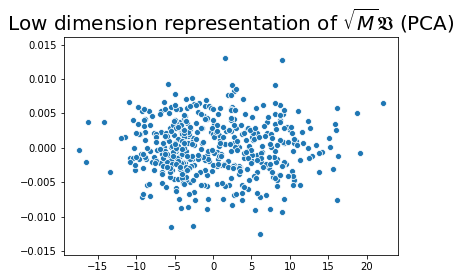

In [455]:
u_pca = PCA(n_components=2).fit_transform(U)
sns.scatterplot(x=u_pca[:,0], y=u_pca[:,1])
plt.title(r'Low dimension representation of $\sqrt{M}\mathfrak{V}$ (PCA)', fontsize=20)
plt.show()

In [395]:
from sklearn.cluster import KMeans

In [423]:
label = KMeans(8).fit(U).labels_

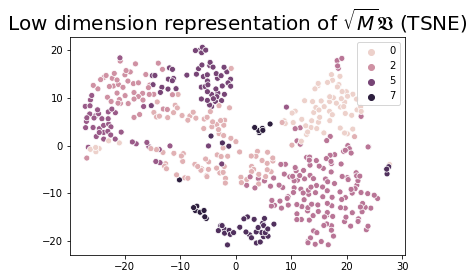

In [424]:
u_pca = TSNE(n_components=2).fit_transform(U)
sns.scatterplot(x=u_pca[:,0], y=u_pca[:,1], hue=label)
plt.title(r'Low dimension representation of $\sqrt{M}\mathfrak{V}$ (TSNE)', fontsize=20)
plt.show()

In [ ]:
class DNFRNet(nn.Module):
    def __init__(self, n_vars, n_class, n_dim):
        super(DNFNet, self).__init__()
        self.v_embedding = nn.Embedding(n_vars, n_dim)
        self.y_embedding = nn.Embedding(n_class, n_dim)
        
        #self.f = nn.Sequential(nn.Linear(n_dim*2, n_dim*2),
        self.f = nn.Sequential(nn.Linear(n_dim, n_dim), 
                              nn.ReLU(),
                              nn.Linear(n_dim, n_dim))
        
        self.g = nn.Sequential(nn.Linear(n_dim, n_dim),
                              nn.ReLU(),
                              nn.Linear(n_dim, n_dim))
        
        self.out = nn.Linear(n_dim, n_class)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def predict(self, vars, mask=None):
        """
        vars: N * max_len
        mask: N * max_len
        """
        l_embedded = self.y_embedding.weight.unsqueeze(0)                # 1 * y * d
        l_embedded = l_embedded.repeat(vars.shape[0], 1, 1) # N * y * d
        l_embedded = l_embedded.transpose(1, 2)     # N * d * y
        v_embedded = self.v_embedding(vars)         # N * max_len * d
        scores = torch.bmm(v_embedded, l_embedded)  # N * max_len * y
        
        
        norm_1 = l_embedded.norm(dim=1).unsqueeze(1) # N * 1 * y
        norm_1 = norm_1.repeat(1, v_embedded.shape[1], 1) # N * max_len * y
        norm_2 = v_embedded.norm(dim=2).unsqueeze(2)  # N * max_len * 1
        norm_2 = norm_2.repeat(1, 1, l_embedded.shape[2]) # N * max_len * y
        
        scores = scores / norm_1
        scores = scores / norm_2
    
        
        mask = mask.unsqueeze(-1).repeat(1, 1, scores.shape[2])
        if mask is not None:
            scores = scores * mask
        scores = scores.sum(1) 
        #print(mask[:,:,0].sum(1))
        #print(scores / mask.sum(1))
        return scores
        
        
    def forward(self, vars, label, neg_vars, mask=None):
        """
        N = n_batch
        vars: N * max_len
        label: N
        neg_vars: N*k
        mask: N*max_len
        """
        
        vars_embedded = self.v_embedding(vars) # N * max_len * d
        label_embedded = self.y_embedding(label) # N * d
        neg_vars_embedded = self.v_embedding(neg_vars) # N * k * d
        
        # correlative score.
        score_pos = torch.bmm(vars_embedded, label_embedded.unsqueeze(2)).squeeze()  # N * max_len 
        score_neg = torch.bmm(neg_vars_embedded, label_embedded.unsqueeze(2)).squeeze()
        
        if mask is not None:
            score_pos[~mask] = float('inf')
        
        score_pos = torch.sum(F.logsigmoid(score_pos), 1)  # N 
        score_neg = torch.sum(F.logsigmoid(-score_neg), 1)
        
            
        # predictive loss.
        scores_pred = self.predict(vars, mask)
        loss_pred = self.criterion(scores_pred, label)
        
        return loss_pred, -score_pos.mean(), -score_neg.mean()